In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
import cmath
import random
import tqdm
import sys, os
sys.path.append(os.pardir)
from collections import OrderedDict
from scipy.special import jn

In [42]:
# 送信ビット生成
# 送信ブロック数
block = 10000

# 一秒間に送るsymbol数
sec_symbol = 1

# 1シンボルのビット数
bit = 2  # 4シンボル
# 学習SNR値
SNRdB = 20

SNR = 10**((-1.0) * (SNRdB / 10.0))

# 雑音の分散
z = SNR

# 初期設定
train_data = np.empty((block, sec_symbol, bit))
teach_data = np.empty((block, sec_symbol, bit))

for i in tqdm.tqdm(range(block)):
    for j in range(sec_symbol):
        d1 = random.randint(0, 1)
        d2 = random.randint(0, 1)

        data = [d1, d2]  # リストに変更
        train_data[i, j] = data
        teach_data[i, j] = data
print(train_data.shape, teach_data.shape)


100%|██████████| 10000/10000 [00:00<00:00, 227334.78it/s]

(10000, 1, 2) (10000, 1, 2)


In [43]:
#QPSK変調(1symbol)
train_data2 = np.zeros((block, sec_symbol, 1), dtype=np.complex128)
for i in tqdm.tqdm(range(block)):
  for j in range(sec_symbol):
    if (train_data[i,j, 0] == 0 and train_data[i,j, 1] == 0):
        train_data2[i][j] = 1 + 1j
    elif (train_data[i,j, 0] == 0 and train_data[i,j, 1] == 1):
      train_data2[i][j] = 1 - 1j
    elif (train_data[i,j, 0] == 1 and train_data[i,j, 1] == 1):
      train_data2[i][j] = -1 - 1j
    elif (train_data[i, j,0] == 1 and train_data[i, j,1] == 0):
      train_data2[i][j] = -1 + 1j

print(train_data2.shape)

100%|██████████| 10000/10000 [00:00<00:00, 331445.01it/s]

(10000, 1, 1)


In [44]:
#雑音
def noise(N):
    z = np.random.normal(0, np.sqrt(N/2))
    return z

In [9]:
"""
#各パラメータの初期値生成
m = 50 #通信経路数
fm = np.zeros((m), dtype=complex)  #各経路のドップラー周波数

am = np.random.rand(m)                 #各経路の振幅
om = np.random.uniform(0, 2*np.pi, m)  #各経路の位相シフト
psi_m =  np.random.uniform(0, 1.7*np.pi, m) #移動ユーザの動きに対する入射電波角度
c = 3*10e8                              # 光速 [m/s]
v = 5                                   #ユーザーの移動速度
fc = 2*10e9            #キャリア周波数 [Hz]

In [45]:
#各パラメータの初期値生成、正規分布
m = 20 #通信経路数
fm = np.zeros((m), dtype=complex)  #各経路のドップラー周波数

am_mean=0
am_std=0.5
am = np.random.normal(am_mean, am_std, size=m)               #各経路の振幅

om_mean = 0
am_std= np.pi
om = np.random.normal(om_mean, am_std, m)            #各経路の位相シフト

psi_mean = 0
psi_std = np.pi
psi_m =  np.random.normal(psi_mean, psi_std, m) #移動ユーザの動きに対する入射電波角度
c = 3*10e8                              # 光速 [m/s]
v = 5                                   #ユーザーの移動速度
fc = 2*10e9            #キャリア周波数 [Hz]

In [46]:
#jakes model fading

def jakes_fading(t):

  #ドップラー周波数の値
  for i in range(m):
    #mean =0  # 平均
    #std_dev = 0.000001*np.pi  # 標準偏差
    #random_p = np.random.normal(mean, std_dev, size=m)

    #for k in range(m):
     # psi_m[k] = psi_m[k] +random_p[k]

    fm[i] = fc*v/c*np.cos(psi_m[i])

  # cm(t)の値
  cm = np.zeros((m) ,dtype=np.complex128)

  for i in range(m):
    x = 2*np.pi*fm[i]*t+om[i]
    cm[i]= am[i]*np.exp(x*1j)

  #パスごとのフェージングを合成
  c_t = np.sum(cm, axis=0)

  return c_t


In [47]:
h = np.zeros((block), dtype=complex) #フェージング値保存用

In [48]:
# シミュレーション用の時間配列生成(0~1秒をblock数でわる)
t = np.linspace(0,1, block)

#受信シンボル
#フェージング付与
for i in tqdm.tqdm(range(block)):
    for j in range(sec_symbol):
      h[i] = jakes_fading(t[i])
      train_data2[i][j][0] = train_data2[i][j][0] *h[i]

100%|██████████| 10000/10000 [00:00<00:00, 11256.91it/s]


In [49]:
#雑音付与
for i in tqdm.tqdm(range(block)):
    for j in range(sec_symbol):
        train_data2[i][j][0] = train_data2[i][j][0] +noise(SNR)

100%|██████████| 10000/10000 [00:00<00:00, 209022.29it/s]


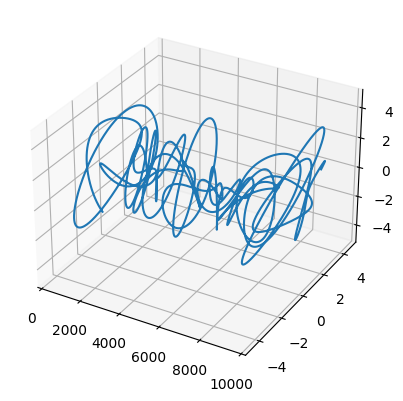

In [52]:
import matplotlib.pyplot as plt

# pl_hから必要なデータを抽出
real_values = h[:].real
imag_values = h[:].imag

# 3Dプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# プロット
ax.plot(range(10000), real_values[:10000], imag_values[:10000])

# グラフの表示範囲を設定（例）
ax.set_xlim(0, 10000)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

# グラフを表示
plt.show()


In [38]:
print(train_data2.shape, teach_data.shape)

(10000, 1, 1) (10000, 1, 2)


In [53]:
#testdata生成
# 送信ビット生成
# 送信ブロック数
block2 = 10000

# 一秒間に送るsymbol数
sec_bit = 1

# 1シンボルのビット数
bit = 2  # 4シンボル
# 学習SNR値
SNRdB = 20
SNR = 10**((-1.0) * (SNRdB / 10.0))

# 雑音の分散
z = SNR

# 初期設定
test_data = np.empty((block2, sec_bit, bit))
teach_test = np.empty((block2, sec_bit, bit))

for i in tqdm.tqdm(range(block2)):
    for j in range(sec_bit):
        d1 = random.randint(0, 1)
        d2 = random.randint(0, 1)

        data = [d1, d2]  # リストに変更
        test_data[i, j] = data
        teach_test[i, j] = data
print(test_data.shape, teach_test.shape)


100%|██████████| 10000/10000 [00:00<00:00, 232723.40it/s]

(10000, 1, 2) (10000, 1, 2)


In [54]:
#QPSK変調(1symbol)
test_data2 = np.zeros((block2, sec_bit, 1), dtype=np.complex128)
for i in tqdm.tqdm(range(block2)):
  for j in range(sec_bit):
    if (test_data[i,j, 0] == 0 and test_data[i,j, 1] == 0):
        test_data2[i][j] = 1 + 1j
    elif (test_data[i,j, 0] == 0 and test_data[i,j, 1] == 1):
      test_data2[i][j] = 1 - 1j
    elif (test_data[i,j, 0] == 1 and test_data[i,j, 1] == 1):
      test_data2[i][j] = -1 - 1j
    elif (test_data[i, j,0] == 1 and test_data[i, j,1] == 0):
      test_data2[i][j] = -1 + 1j

print(test_data2.shape)

100%|██████████| 10000/10000 [00:00<00:00, 349790.59it/s]

(10000, 1, 1)


In [16]:
"""
#各パラメータの初期値生成
m = 15 #通信経路数
fm = np.zeros((m), dtype=complex)  #各経路のドップラー周波数

am = np.random.rand(m)  #各経路の振幅
om = np.random.uniform(0, 2*np.pi, m)  #各経路の位相シフト
psi_m =  np.random.uniform(0, 1.7*np.pi, m) #移動ユーザの動きに対する入射電波角度
c = 3*10e8             # 光速 [m/s]
v = 6               #ユーザーの移動速度
fc = 2*10e9            #キャリア周波数 [Hz]
"""

In [55]:
#各パラメータの初期値生成、正規分布
m = 20 #通信経路数
fm = np.zeros((m), dtype=complex)  #各経路のドップラー周波数

am_mean=0
am_std=0.5
am = np.random.normal(am_mean, am_std, size=m)               #各経路の振幅

om_mean = 0
am_std= np.pi
om = np.random.normal(om_mean, am_std, m)            #各経路の位相シフト

psi_mean = 0
psi_std = np.pi
psi_m =  np.random.normal(psi_mean, psi_std, m) #移動ユーザの動きに対する入射電波角度
c = 3*10e8                              # 光速 [m/s]
v = 5                                   #ユーザーの移動速度
fc = 2*10e9            #キャリア周波数 [Hz]

In [56]:
h2 = np.zeros((block2), dtype=complex)

In [57]:
# シミュレーション用の時間配列生成(0~1秒をblock数でわる)
t = np.linspace(0, 1, block2)

#受信シンボル
#フェージング付与
for i in tqdm.tqdm(range(block2)):
    for j in range(sec_symbol):
      h2[i] = jakes_fading(t[i])
      test_data2[i][j][0] = test_data2[i][j][0] *h2[i]

100%|██████████| 10000/10000 [00:01<00:00, 6617.63it/s]


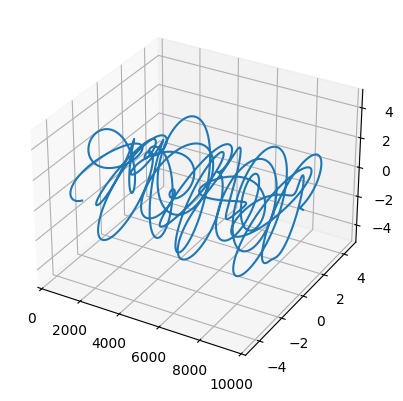

In [58]:
import matplotlib.pyplot as plt

# pl_hから必要なデータを抽出
real_values = h2[:].real
imag_values = h2[:].imag

# 3Dプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# プロット
ax.plot(range(10000), real_values[:10000], imag_values[:10000])

# グラフの表示範囲を設定（例）
ax.set_xlim(0, 10000)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

# グラフを表示
plt.show()


In [59]:
#コピー
#snrtestdata
#BER/SNR:0~20
SNRdB_test = 0
BER = 0
test_data3 = np.zeros((20, block2, sec_bit,1), dtype=np.complex128)

for i in tqdm.tqdm(range(20)):
  SNRdB_test +=1
  SNR = 10**((-1.0)*(SNRdB_test/10.0))

  #雑音付与
  for j in range(block2):
    for k in range(sec_bit):
        test_data3[i][j][k][0] = test_data2[j][k][0] +noise(SNR)
        #print(snr_test2[i][j]) 複素

100%|██████████| 20/20 [00:00<00:00, 22.58it/s]


In [60]:
teach_test2 = np.zeros((20, block2, sec_bit,2))
for i in range(20):
  for j in range(block2):
    for k in range(sec_bit):
      teach_test2[i][j][k] =teach_test[j][k]


In [61]:
print(train_data2.shape, teach_data.shape)
print(test_data3.shape, teach_test2.shape)

(10000, 1, 1) (10000, 1, 2)
(20, 10000, 1, 1) (20, 10000, 1, 2)


In [62]:
train_data3 = train_data2.reshape(10000, 1)
teach_train= teach_data.reshape(10000, 2)
test_data4 = test_data3.reshape(20,10000, 1)
teach_test3 = teach_test2.reshape(20,10000, 2)

In [64]:
#学習データ保存
np.savez('jaks_data_online.npz',train_data3, teach_train, test_data4, teach_test3)